# Реализация байесовской линейной регрессии

In [19]:
# Импортируем Pandas and numpy
import pandas as pd
import numpy as np

# Matplotlib и seaborn для визуализации
import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns

# Линейная регрессия для проверки распредления
from sklearn.linear_model import LinearRegression

# Scipy для статистики
import scipy

# PyMC3 для Байесовского вывода
import pymc3 as pm

# Загружаем данные

In [20]:
exercise = pd.read_csv('./data/exercise.csv')
calories = pd.read_csv('./data/calories.csv')
df = pd.merge(exercise, calories, on = 'User_ID')
df = df[df['Calories'] < 300]
df = df.reset_index()
df['Intercept'] = 1
df.head()

,index,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Intercept
0,0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0,1
1,1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0,1
2,2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0,1
3,3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0,1
4,4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0,1


In [21]:
exercise.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8


# Построим график зависимости

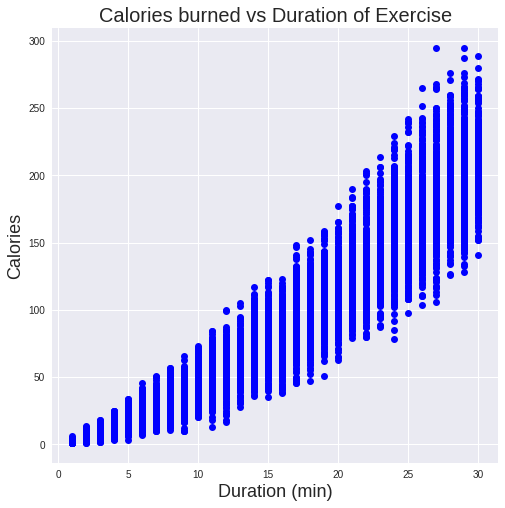

In [22]:
plt.figure(figsize=(8, 8))

plt.plot(df['Duration'], df['Calories'], 'bo');
plt.xlabel('Duration (min)', size = 18); plt.ylabel('Calories', size = 18); 
plt.title('Calories burned vs Duration of Exercise', size = 20);

In [23]:
# Предикативные переменные и предсказание
X = df.loc[:, ['Intercept', 'Duration']]
y = df.ix[:, 'Calories']

/home/paavo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until


# Пишем наименьшие квадраты своими руками

In [24]:
# Вход: матрица признаков и целевой вектор
# выход: веса модели
def linear_regression(X, y):
    # Equation for linear regression coefficients
    beta = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T, X)), X.T), y)
    return beta

In [25]:
# ручной запуск
by_hand_coefs = linear_regression(X, y)
print('Intercept calculated by hand:', by_hand_coefs[0])
print('Slope calculated by hand: ', by_hand_coefs[1])

Intercept calculated by hand: -21.82810252605084
Slope calculated by hand:  7.169783349587853


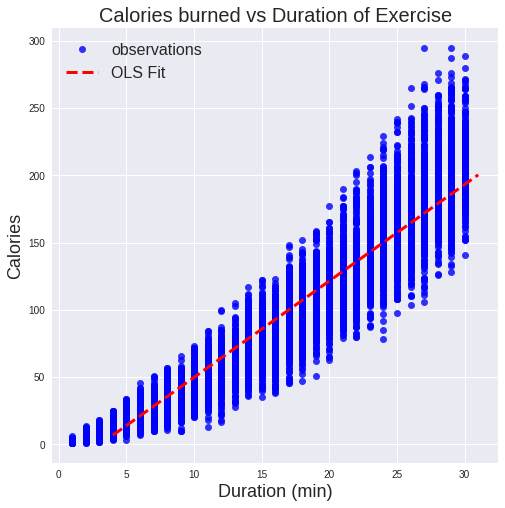

In [26]:
xs = np.linspace(4, 31, 1000)
ys = by_hand_coefs[0] + by_hand_coefs[1] * xs

plt.figure(figsize=(8, 8))
plt.plot(df['Duration'], df['Calories'], 'bo', label = 'observations', alpha = 0.8);
plt.xlabel('Duration (min)', size = 18); plt.ylabel('Calories', size = 18); 
plt.plot(xs, ys, 'r--', label = 'OLS Fit', linewidth = 3)
plt.legend(prop={'size': 16})
plt.title('Calories burned vs Duration of Exercise', size = 20);

# Предсказание значения

In [27]:
print('15.5 минут будут стоить {:.2f} калорий.'.format(
    by_hand_coefs[0] + by_hand_coefs[1] * 15.5))

15.5 минут будут стоить 89.30 калорий.


# Проверка sklearn

In [28]:
# Create the model and fit on the data
lr = LinearRegression()
lr.fit(X.Duration.reshape(-1, 1), y)
print('Intercept from library:', lr.intercept_)
print('Slope from library:', lr.coef_[0])

/home/paavo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


Intercept from library: -21.828102526050813
Slope from library: 7.169783349587853


# Байесовская линейная регрессия

### PyMC3 для байесовского вывода

Реализуем Монте Карло на марковских цепях (MCMC) для нахождения апосториарного распределения параметров модели. 

## Млдель с 500 наблюдениями

In [29]:
with pm.Model() as linear_model_500:
    # сдвиг
    intercept = pm.Normal('Intercept', mu = 0, sd = 10)
    
    # наклон
    slope = pm.Normal('slope', mu = 0, sd = 10)
    
    # стандартное отклонение
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    # оценка среднего
    mean = intercept + slope * X.loc[0:499, 'Duration']
    
    # предскзание
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = y.values[0:500])
    
    # взятие образцов
    step = pm.NUTS()

    # Постериарное распредление
    linear_trace_500 = pm.sample(1000, step)

/home/paavo/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, slope, Intercept]
100%|██████████| 1500/1500 [00:09<00:00, 150.88it/s]
The acceptance probability does not match the target. It is 0.8967720631362627, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8820198516086297, but should be close to 0.8. Try to increase the number of tuning steps.


## Модель со всеми измерениями

In [30]:
with pm.Model() as linear_model:
    # Intercept
    intercept = pm.Normal('Intercept', mu = 0, sd = 10)
    
    # Slope 
    slope = pm.Normal('slope', mu = 0, sd = 10)
    
    # Standard deviation
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    # Estimate of mean
    mean = intercept + slope * X.loc[:, 'Duration']
    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = y.values)
    
    # Sampler
    step = pm.NUTS()

    # Posterior distribution
    linear_trace = pm.sample(1000, step)

/home/paavo/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, slope, Intercept]
100%|██████████| 1500/1500 [00:20<00:00, 73.00it/s]
The acceptance probability does not match the target. It is 0.9652233510753835, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9763142512475957, but should be close to 0.8. Try to increase the number of tuning steps.


## Изучим параметры

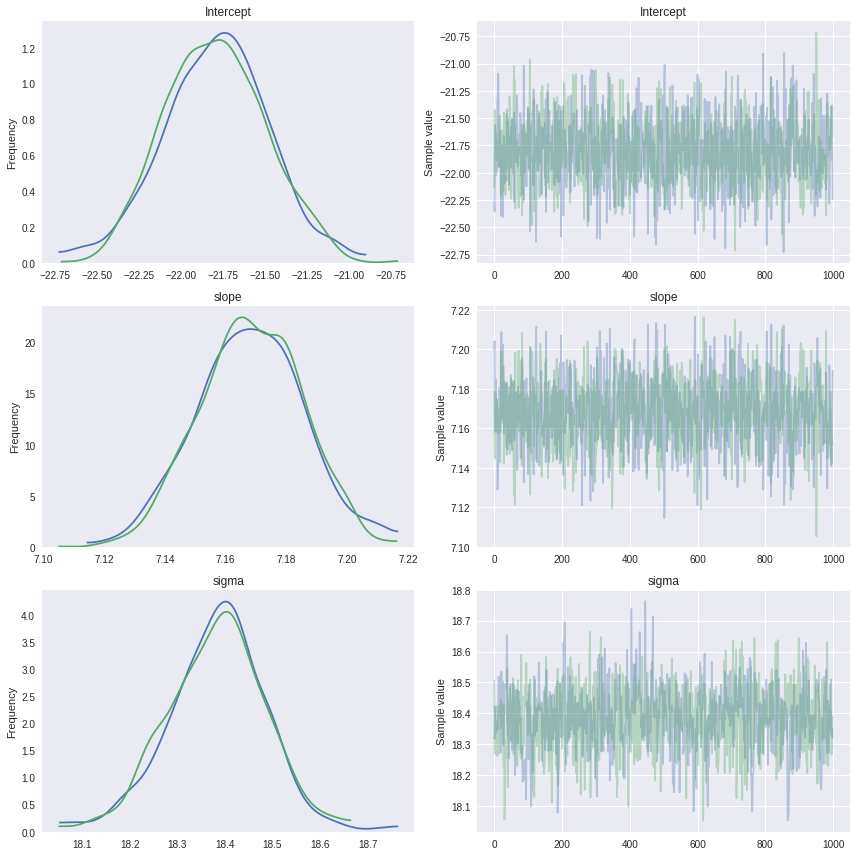

In [31]:
pm.traceplot(linear_trace, figsize = (12, 12));

## Постериарное распределние параметров модели

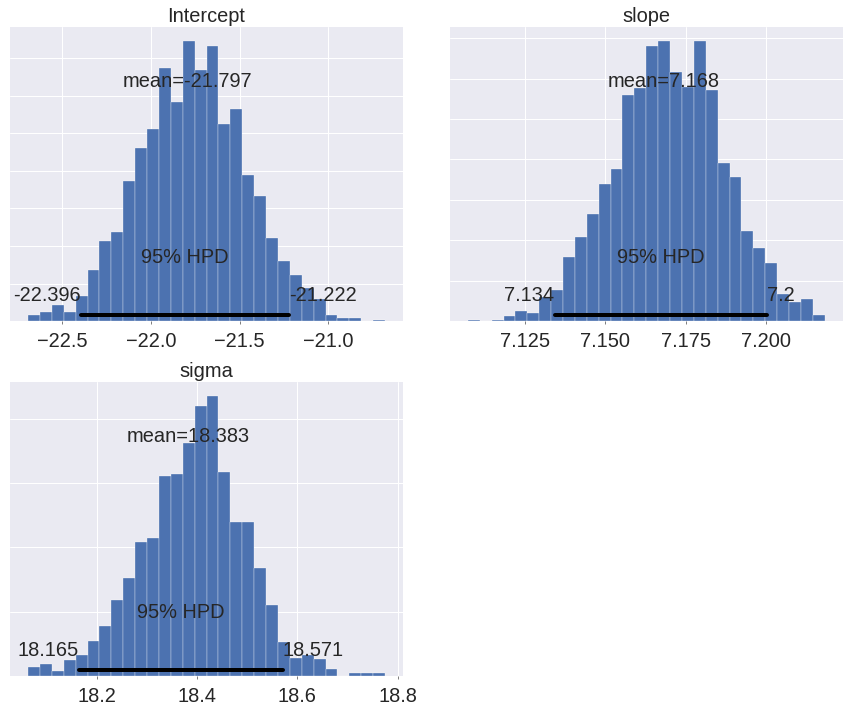

In [32]:
pm.plot_posterior(linear_trace, figsize = (12, 10), text_size = 20);

## Доверительные интервалы

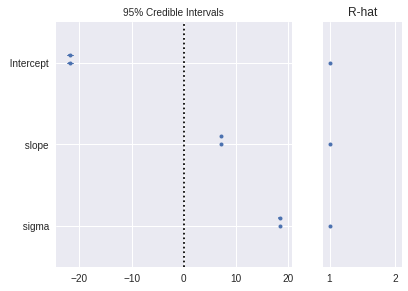

In [33]:
pm.forestplot(linear_trace);

# Predictions of Response Sampled from the Posterior

We can now generate predictions of the linear regression line using the model results. The following plot shows 1000 different estimates of the regression line drawn from the posterior. The distribution of the lines gives an estimate of the uncertainty in the estimate. Bayesian Linear Regression has the benefit that it gives us a posterior __distribution__ rather than a __single point estimate__ in the frequentist ordinary least squares regression.

## All Observations

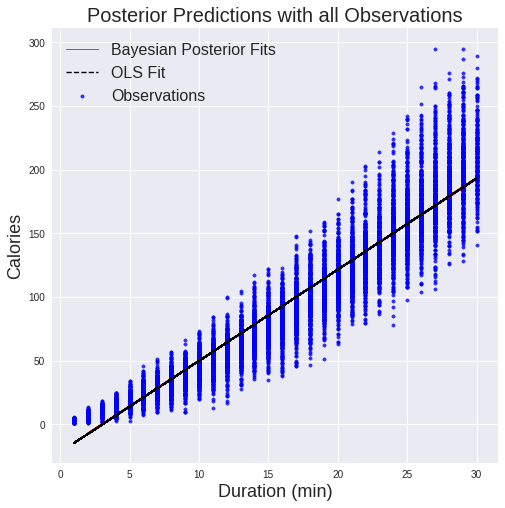

In [34]:
plt.figure(figsize = (8, 8))
pm.plot_posterior_predictive_glm(linear_trace, samples = 100, eval=np.linspace(2, 30, 100), linewidth = 1, 
                                 color = 'red', alpha = 0.8, label = 'Bayesian Posterior Fits',
                                lm = lambda x, sample: sample['Intercept'] + sample['slope'] * x);
plt.scatter(X['Duration'], y.values, s = 12, alpha = 0.8, c = 'blue', label = 'Observations')
plt.plot(X['Duration'], by_hand_coefs[0] + X['Duration'] * by_hand_coefs[1], 'k--', label = 'OLS Fit', linewidth = 1.4)
plt.title('Posterior Predictions with all Observations', size = 20); plt.xlabel('Duration (min)', size = 18);
plt.ylabel('Calories', size = 18);
plt.legend(prop={'size': 16});

In [35]:
pm.df_summary(linear_trace)

/home/paavo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: df_summary has been deprecated. In future, use summary instead.
  """Entry point for launching an IPython kernel.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,-21.796867,0.302607,0.009672,-22.395539,-21.221510,874.0,0.999629
slope,7.168042,0.017158,0.000538,7.134138,7.200332,844.0,0.999704
sigma,18.382815,0.102349,0.003765,18.164743,18.570851,702.0,1.000048


## Limited Observations

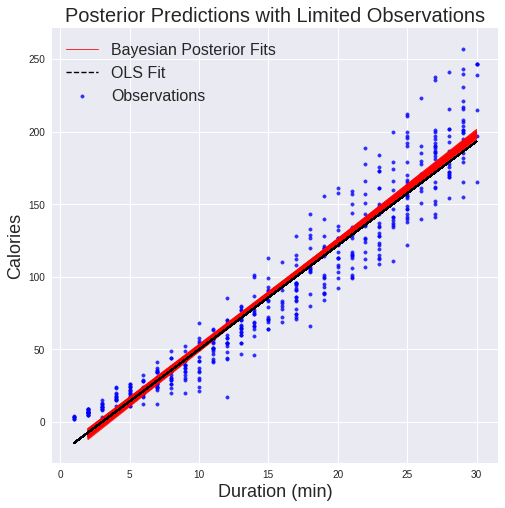

In [36]:
plt.figure(figsize = (8, 8))
pm.plot_posterior_predictive_glm(linear_trace_500, samples = 100, eval=np.linspace(2, 30, 100), linewidth = 1, 
                                 color = 'red', alpha = 0.8, label = 'Bayesian Posterior Fits',
                                lm = lambda x, sample: sample['Intercept'] + sample['slope'] * x);
plt.scatter(X['Duration'][:500], y.values[:500], s = 12, alpha = 0.8, c = 'blue', label = 'Observations')
plt.plot(X['Duration'], by_hand_coefs[0] + X['Duration'] * by_hand_coefs[1], 'k--', label = 'OLS Fit', linewidth = 1.4)
plt.title('Posterior Predictions with Limited Observations', size = 20); plt.xlabel('Duration (min)', size = 18);
plt.ylabel('Calories', size = 18);
plt.legend(prop={'size': 16});

In [37]:
pm.df_summary(linear_trace_500)

/home/paavo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: df_summary has been deprecated. In future, use summary instead.
  """Entry point for launching an IPython kernel.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,-22.768176,1.716874,0.062564,-26.335155,-19.678200,713.0,1.001159
slope,7.351878,0.094794,0.003391,7.166935,7.541691,715.0,1.000277
sigma,18.192515,0.585739,0.016275,17.009448,19.275011,1218.0,0.999568


# Specific Prediction for One Datapoint

In [38]:
bayes_prediction = linear_trace['Intercept'] + linear_trace['slope'] * 15.5

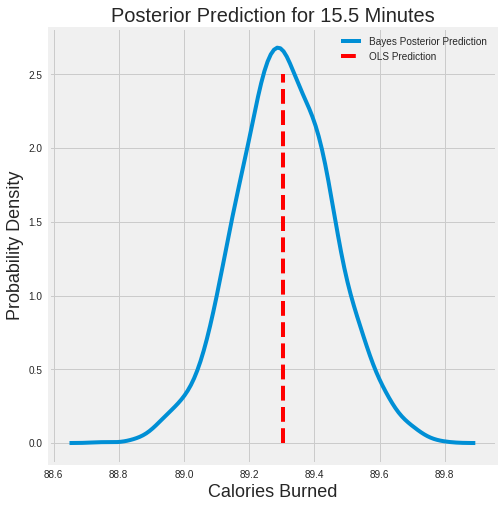

In [39]:
plt.figure(figsize = (8, 8))
plt.style.use('fivethirtyeight')
sns.kdeplot(bayes_prediction, label = 'Bayes Posterior Prediction')
plt.vlines(x = by_hand_coefs[0] + by_hand_coefs[1] * 15.5, 
           ymin = 0, ymax = 2.5, 
           label = 'OLS Prediction',
          colors = 'red', linestyles='--')
plt.legend();
plt.xlabel('Calories Burned', size = 18), plt.ylabel('Probability Density', size = 18);
plt.title('Posterior Prediction for 15.5 Minutes', size = 20);